<a href="https://colab.research.google.com/github/iceman025/bank-assignment-02/blob/main/assignment_02_QICAI_HE_bank_analysis0809.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# load packages

library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
install.packages("caret")
library(caret)
install.packages("vtreat")
library(vtreat)
install.packages("FSelector")
library(FSelector)
install.packages("glmnet")
library(glmnet)
library(e1071)
library(magrittr)
install.packages("wesanderson")
library(wesanderson)
install.packages("ggpubr")
library(ggpubr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘minqa’, ‘nloptr’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’




In [ ]:
# data exploration 
df_bank<-read_delim("https://raw.githubusercontent.com/iceman025/bank-assignment-02/main/bank-additional-full.csv",delim = ";")
str(df_bank)
head(df_bank)
sum(is.na(df_bank))
glimpse(df_bank)

In [27]:
# inspect column
table(df_bank$job)
# check if any  empty columns
colSums(is.na(df_bank))



       admin.   blue-collar  entrepreneur     housemaid    management 
        10422          9254          1456          1060          2924 
      retired self-employed      services       student    technician 
         1720          1421          3969           875          6743 
   unemployed       unknown 
         1014           330 

age            job        marital      education        default 
             0              0              0              0              0 
       housing           loan        contact          month    day_of_week 
             0              0              0              0              0 
      duration       campaign          pdays       previous       poutcome 
             0              0              0              0              0 
  emp.var.rate cons.price.idx  cons.conf.idx      euribor3m    nr.employed 
             0              0              0              0              0 
             y 
             0

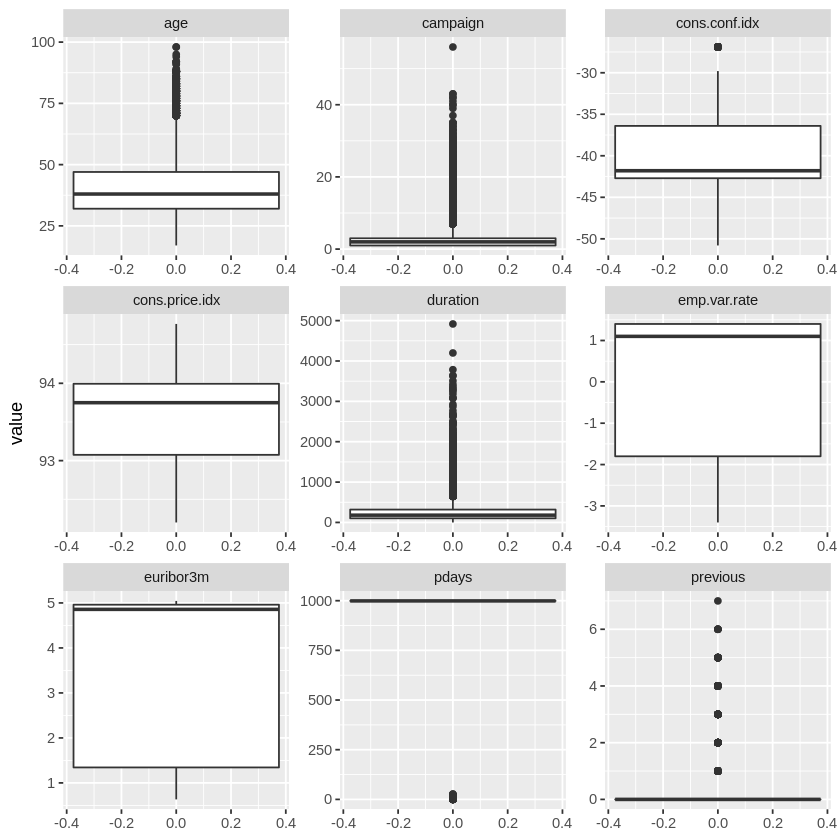

In [28]:
# explore the distribution and inspect outliers in the numerical variables
# boxplots
df_bank%>% 
select_if(is.numeric) %>% 
pivot_longer(cols=c(1:9),names_to = "variable",values_to = "value") %>% 
   ggplot(aes(y=value))+geom_boxplot()+facet_wrap(~variable,scales="free")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



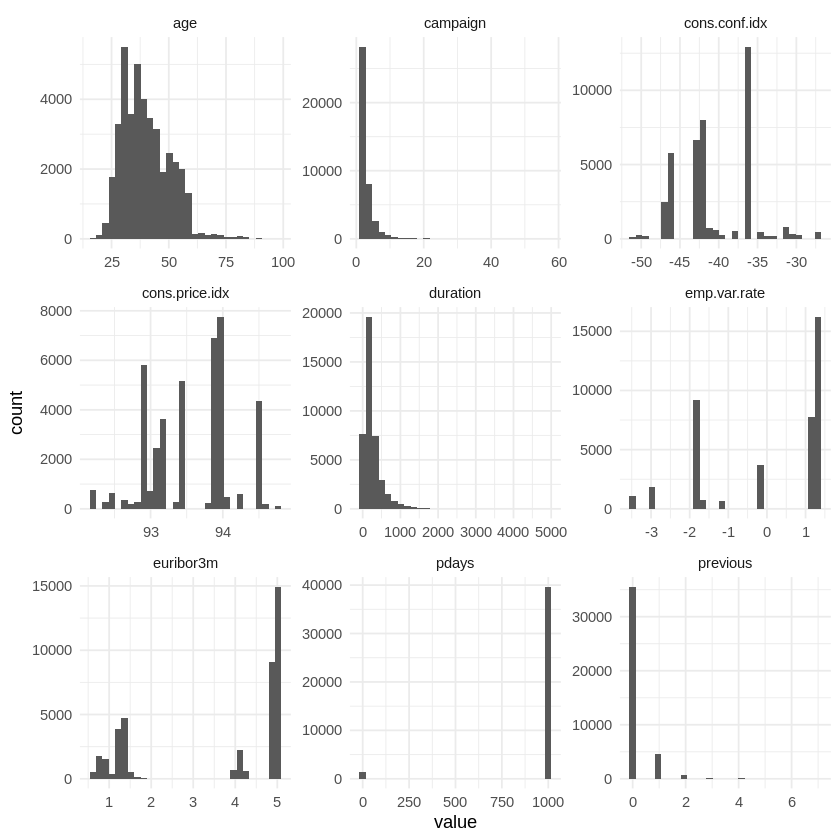

In [29]:
# histogram
# The variables pdays and euribor3m are skewed to the left.The variables campaign, duration and previous are skewed to the right.

df_bank%>% 
select_if(is.numeric) %>% 
pivot_longer(cols=c(1:9),names_to = "variable",values_to = "value") %>% 
   ggplot(aes(y=value))+geom_histogram()+facet_wrap(~variable,scales="free")+coord_flip()+theme_minimal()

In [30]:
# Bar Plot
df_bank<-df_bank %>% 
  mutate(y=as.factor(y)) %>% 
  mutate(y=ifelse(y=="yes",1,0)) %>% 
  mutate_if(is.character,as.factor)


In [31]:
# Splitting Data 
# split the data into 70% train set and 30% test set.
RNGkind(sample.kind = "Rounding")
set.seed(125)
row_data <- nrow(df_bank)

index <- sample(row_data, row_data*0.7)

data_train <- df_bank[ index, ]
data_test <- df_bank[ -index, ]
data_train<-data_train %>% mutate(y=as.factor(y))
data_test<-data_test %>% mutate(y=as.factor(y))

Warning message in RNGkind(sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


In [32]:
x_train<-as.data.frame(data_train) %>% select(-y)
y_train<-data_train$y
x_test<-as.data.frame(data_test) %>% select(-y)
y_test<-data_test$y

In [33]:
# Downsampling
#  classes of the response variable is imbalanced.
prop.table(table(y_train))



y_train
        0         1 
0.8888349 0.1111651 

In [34]:
# Logistic Regression Modeling-step
model_full<-glm(y~.,data_train, family = "binomial")

model_null<-glm(y~1,data_train, family = "binomial")
model_logistic_step <- step(model_null, 
                   scope = list(lower = model_null, upper = model_full),
                   direction = "both"
                   )

Start:  AIC=20122.82
y ~ 1

                 Df Deviance   AIC
+ duration        1    16646 16650
+ nr.employed     1    17090 17094
+ euribor3m       1    17665 17669
+ emp.var.rate    1    17842 17846
+ pdays           1    18392 18396
+ poutcome        2    18419 18425
+ month           9    18634 18654
+ previous        1    19117 19121
+ contact         1    19445 19449
+ job            11    19560 19584
+ cons.price.idx  1    19618 19622
+ default         2    19841 19847
+ campaign        1    19952 19956
+ education       7    19982 19998
+ cons.conf.idx   1    20032 20036
+ marital         3    20047 20055
+ age             1    20100 20104
+ day_of_week     4    20097 20107
<none>                 20121 20123
+ housing         2    20118 20124
+ loan            2    20119 20125

Step:  AIC=16649.79
y ~ duration

                 Df Deviance   AIC
+ nr.employed     1    13137 13143
+ euribor3m       1    13723 13729
+ emp.var.rate    1    13884 13890
+ poutcome        2    1483

In [35]:
model <- glm(formula = as.factor(y) ~age+job+marital+education+default+housing+loan+contact+month+day_of_week+duration+campaign+pdays+previous+poutcome+emp.var.rate, family = "binomial", data = df_bank)
     summary(model)


Call:
glm(formula = as.factor(y) ~ age + job + marital + education + 
    default + housing + loan + contact + month + day_of_week + 
    duration + campaign + pdays + previous + poutcome + emp.var.rate, 
    family = "binomial", data = df_bank)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.0777  -0.3184  -0.1989  -0.1337   3.2424  

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -3.686e+00  3.011e-01 -12.244  < 2e-16 ***
age                           2.962e-03  2.401e-03   1.234 0.217213    
jobblue-collar               -2.940e-01  7.895e-02  -3.724 0.000196 ***
jobentrepreneur              -2.714e-01  1.245e-01  -2.181 0.029211 *  
jobhousemaid                 -1.833e-02  1.459e-01  -0.126 0.899986    
jobmanagement                -1.315e-01  8.439e-02  -1.558 0.119147    
jobretired                    3.257e-01  1.053e-01   3.092 0.001988 ** 
jobself

In [36]:
model <- glm(formula =y~duration + month + poutcome + emp.var.rate + job + cons.price.idx + 
    contact + euribor3m + day_of_week + campaign + pdays + education + 
    cons.conf.idx + default , 
 family = "binomial", data = data_train)
     summary(model_full)


Call:
glm(formula = y ~ ., family = "binomial", data = data_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.9890  -0.2985  -0.1855  -0.1338   3.1522  

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -2.240e+02  4.663e+01  -4.804 1.56e-06 ***
age                          -1.824e-03  2.925e-03  -0.624 0.532905    
jobblue-collar               -2.078e-01  9.718e-02  -2.139 0.032472 *  
jobentrepreneur              -2.188e-01  1.600e-01  -1.368 0.171424    
jobhousemaid                  1.036e-01  1.765e-01   0.587 0.557311    
jobmanagement                -6.840e-02  1.038e-01  -0.659 0.509914    
jobretired                    3.985e-01  1.289e-01   3.091 0.001993 ** 
jobself-employed             -5.423e-02  1.354e-01  -0.400 0.688815    
jobservices                  -4.100e-02  1.023e-01  -0.401 0.688503    
jobstudent                    2.381e-01  1

[1] 11951.73

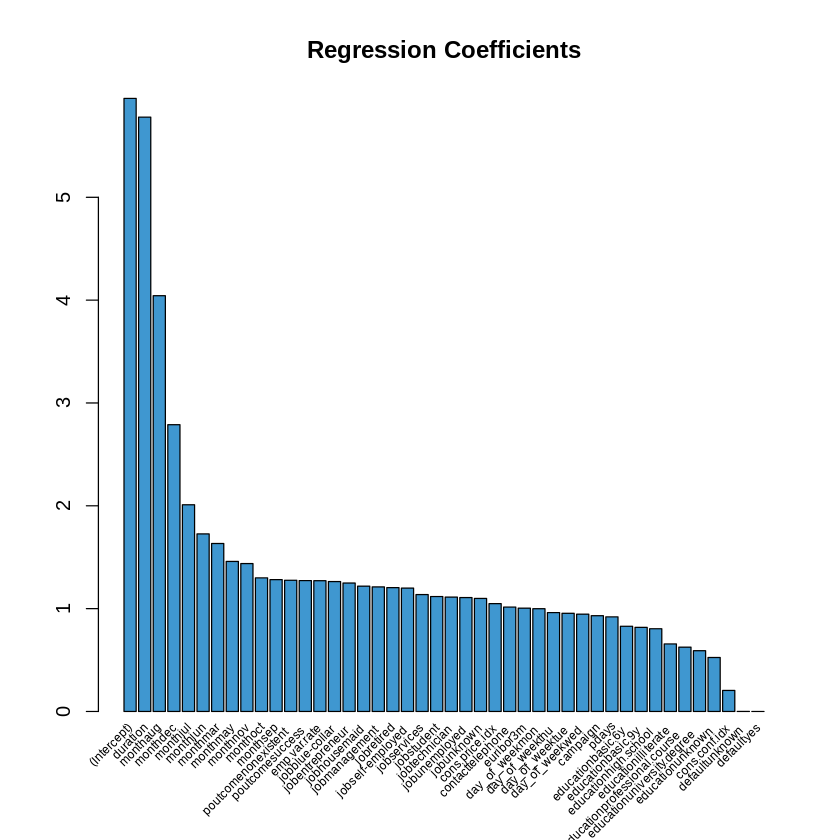

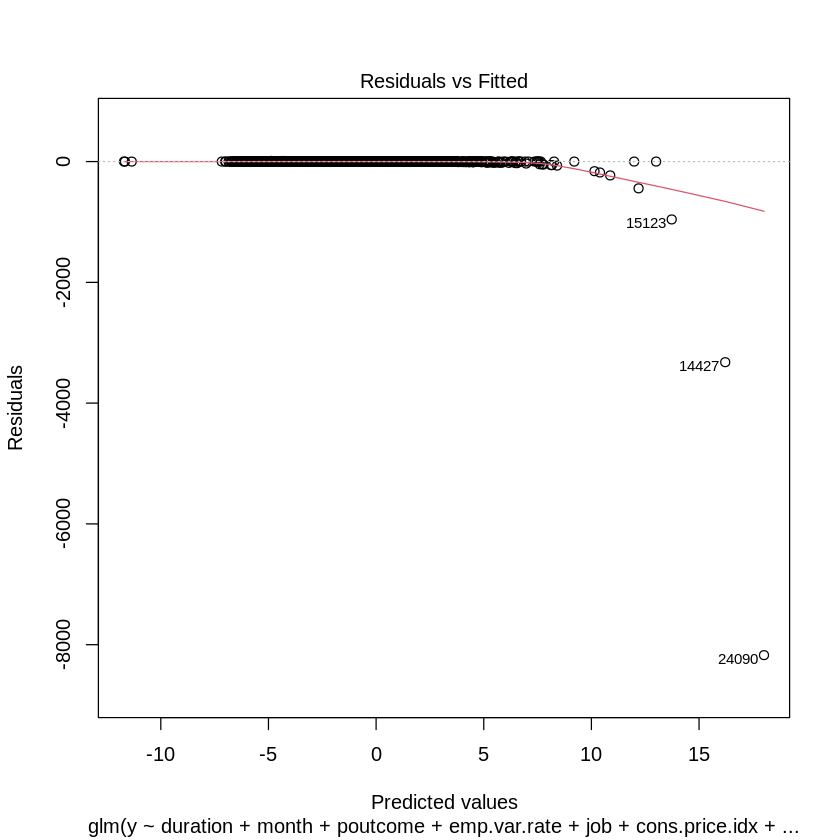

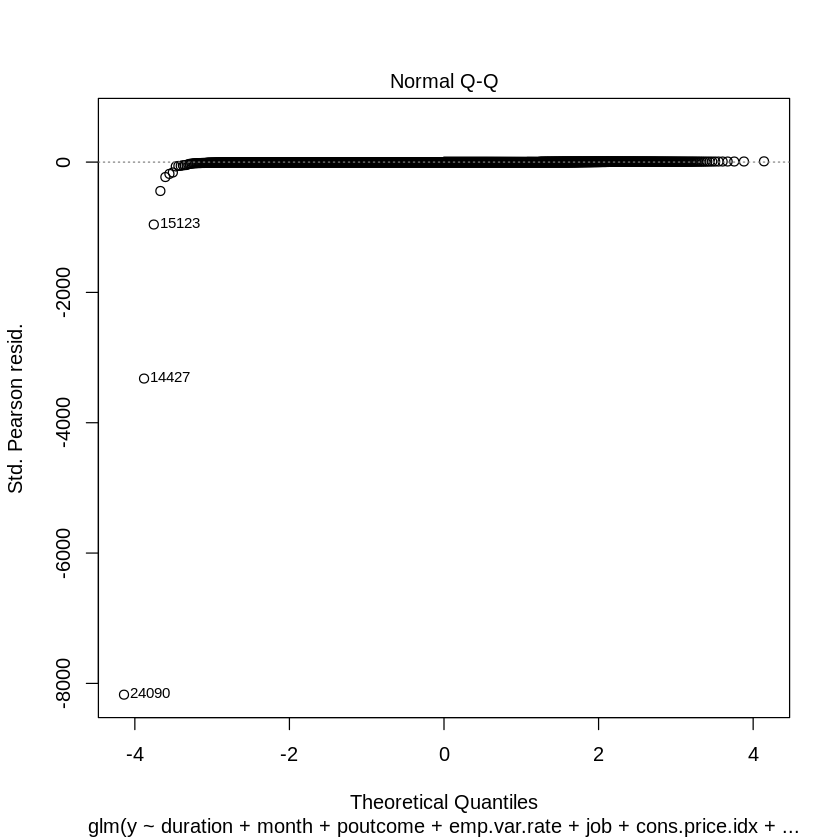

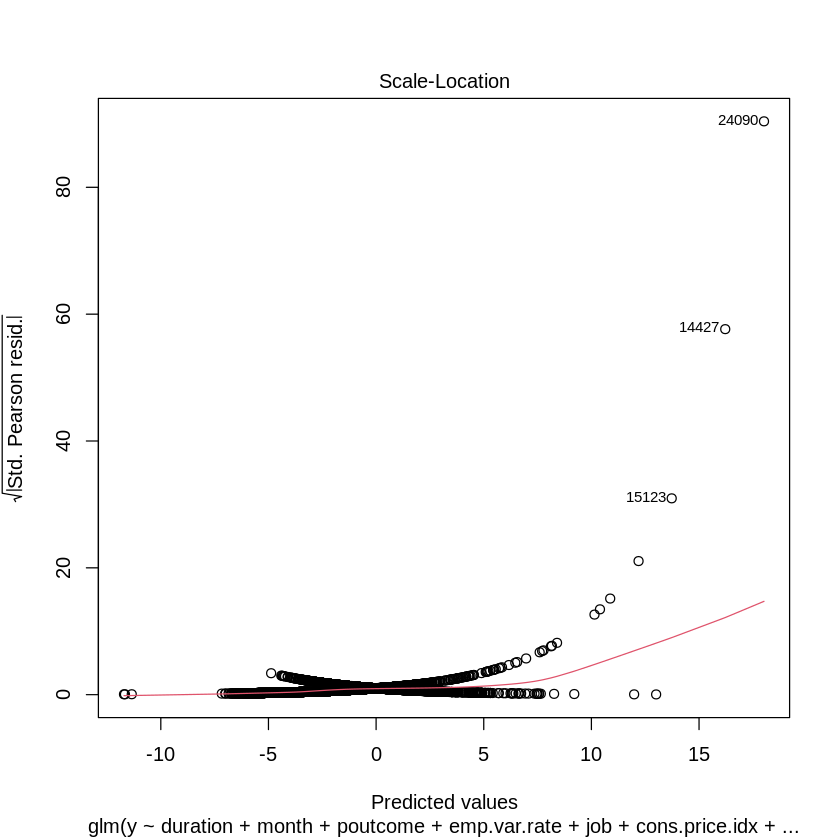

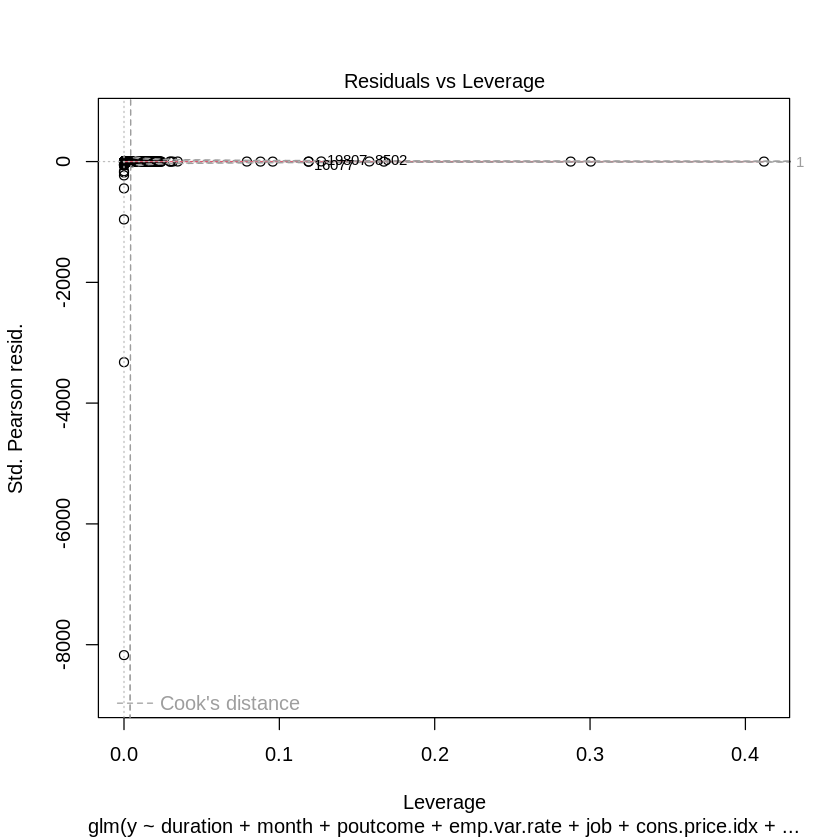

In [37]:
# Plotting Coefficients
# plot the model coefficients to examine which variable of the model increases the odds the most.
plot_coeffs <- function(mlr_model) {
      coeffs <- exp(coefficients(mlr_model))
      mp <- barplot(coeffs[order(coeffs,decreasing = T)], col="#3F97D0", xaxt='n', main="Regression Coefficients")
      lablist <- names(coeffs)
      text(mp, par("usr")[3], labels = lablist, srt = 45, adj = c(1.1,1.1), xpd = TRUE, cex=0.6)
}

plot_coeffs(model)
AIC(model)
plot(model)

In [38]:
# predict and examine our model’s performance
ptrain <- predict(model, data_train, type = "response") 
ptest <- predict(model, data_test, type = "response")

glimpse(ptest)
str(ptest)
glimpse(ptrain)
str(ptrain)

 Named num [1:12357] 0.01388 0.01829 0.02906 0.01233 0.00707 ...
 - attr(*, "names")= chr [1:12357] "1" "2" "3" "4" ...
 Named num [1:12357] 0.01388 0.01829 0.02906 0.01233 0.00707 ...
 - attr(*, "names")= chr [1:12357] "1" "2" "3" "4" ...
 Named num [1:28831] 0.15132 0.00861 0.03858 0.27648 0.06298 ...
 - attr(*, "names")= chr [1:28831] "1" "2" "3" "4" ...
 Named num [1:28831] 0.15132 0.00861 0.03858 0.27648 0.06298 ...
 - attr(*, "names")= chr [1:28831] "1" "2" "3" "4" ...


In [41]:
predicted_step<-predict(model_logistic_step,x_test,type="response")
pred_step_test <- ifelse(predicted_step > 0.5, 1, 0) %>% as.factor()
cm_step<-confusionMatrix(pred_step_test,y_test,positive = "1")
cm_step

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 10635   828
         1   287   607
                                          
               Accuracy : 0.9098          
                 95% CI : (0.9046, 0.9148)
    No Information Rate : 0.8839          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4744          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.42300         
            Specificity : 0.97372         
         Pos Pred Value : 0.67897         
         Neg Pred Value : 0.92777         
             Prevalence : 0.11613         
         Detection Rate : 0.04912         
   Detection Prevalence : 0.07235         
      Balanced Accuracy : 0.69836         
                                          
       'Positive' Class : 1               
                  

**conclusion and analysis：


**1. Variable Description**
This dataset contains 21 columns of data, which consists of 20 predictors and 1 to be predicted variables. The variable to be predicted is y, in which the customer end up making a deposit in the bank or not. 

**2. Boxplot**：It seems like the distribution of our variables are skewed, especially the variables age, campaign, duration, pdays, previous. 

**3. Histogram：**

*   The variables pdays and euribor3m are skewed to the left.
*   The variables campaign, duration and previous are skewed to the right.

**4. Bar Plot：**From the plot above, we can see that most of the people that ended up making a term deposit subscription are :
Are Married
Is an Admin by profession

5. Since the predicted variable in our first model which is the logistic regression will be in probability, we will convert all of the target variables into numeric first.

**6. Splitting Data**
To reduce the chance of overfiting our data, we are going to split the data into training and testing set in order to then check our model’s performance after the modeling step. In this project, we are going to split the data into 70% train set and 30% test set.

**7. Downsampling：** As shown from the result above, there is around 89% of responses which corresponds to 0, and only around 11% of the responses corresponds to 1.

**8. Logistic Regression **bold text**
Modeling， a stepwise logistic regression on our data

9. Plotting Coefficients** **
plot the model coefficients to examine which variable of the model increases the odds the most.
**10. model:**
Accuracy : 0.9098          
                 95% CI : (0.9046, 0.9148)
    No Information Rate : 0.8839          
    P-Value [Acc > NIR] : < 2.2e-16     

  from above, this model fits well 
